# Lab 7 - Web Scraping
---
In today's lab, we are going to download data from the internet using an API. API stands for application programming interface. Companies often create APIs as a way to allow users to more directly interact with their servers to retrieve data. Today, we are going to be using CKAN's API to download data from the City of Toronto's Open Data Portal to get some experience working with larger datasets.

In [81]:
# Run this cell to set up your notebook
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import warnings
import requests
from ckan_utils import *
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)

%matplotlib inline
import re
import json

## Setup
---
If you are having trouble with any of the following cells, you can read in an already downloaded version of the dataset. 

In [2]:
# toronto public library info

# Toronto Open Data is stored in a CKAN instance. It's APIs are documented here:
# https://docs.ckan.org/en/latest/api/

# To hit our API, you'll be making requests to:
base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

# Datasets are called "packages". Each package can contain many "resources"
# To retrieve the metadata for this package and its resources, use the package name in this page's URL:
url = base_url + "/api/3/action/package_show"
params = { "id": "library-branch-general-information"}
package = requests.get(url, params = params).json()

In [3]:
package

{'help': 'https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/help_show?name=package_show',
 'success': True,
 'result': {'author': 'planning@tpl.ca',
  'author_email': 'planning@tpl.ca',
  'creator_user_id': '329e1506-b545-4fc7-a4ea-e614f220eea7',
  'dataset_category': 'Table',
  'date_published': '2023-06-29 00:00:00',
  'excerpt': 'This dataset shows the current characteristics of Toronto Public Library branches, such as location, size, and the availability of specific features (e.g. parking, KidsStops, Digital Innovation Hubs, etc.)',
  'formats': 'CSV,JSON,XML',
  'id': 'f5aa9b07-da35-45e6-b31f-d6790eb9bd9b',
  'information_url': 'https://www.torontopubliclibrary.ca/opendata',
  'is_retired': 'false',
  'isopen': False,
  'last_refreshed': '2023-06-29 13:48:12.063852',
  'license_id': 'open-government-licence-toronto',
  'license_title': 'open-government-licence-toronto',
  'maintainer': None,
  'maintainer_email': 'planning@tpl.ca',
  'metadata_created': '2023-06-29T14:2

This is an example of another `python` data structure called a *dictionary*. Dictionaries store *values* by associating them with a *key* rather than by an integer index. You can access the values stored in a dictionary using bracket notation just like a list. For example:

In [4]:
# In this dictionary, the keys are strings, and the values are all numbers
d = {'a': 1,
    'b': 2,
    'c': 3}

d['a']

1

In the case of `package`, it is an example of a nested dictionary. To access its values, we need to use a key of a key. It would also appear that there are many values to access, so instead of hard coding the keys one at a time, let's use Python's list comprehension to print all of them out at once. 

In [15]:
package.keys()

dict_keys(['help', 'success', 'result'])

In [16]:
package.values()

dict_values(['https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/help_show?name=package_show', True, {'author': 'planning@tpl.ca', 'author_email': 'planning@tpl.ca', 'creator_user_id': '329e1506-b545-4fc7-a4ea-e614f220eea7', 'dataset_category': 'Table', 'date_published': '2023-06-29 00:00:00', 'excerpt': 'JSON data providing details on upcoming programs and events offered at Toronto Public Library branches.', 'formats': 'CSV,XML,JSON', 'id': 'fb343332-03cd-40b9-a1c8-c03a4a85ca1e', 'information_url': 'https://www.torontopubliclibrary.ca/opendata', 'is_retired': 'false', 'isopen': False, 'last_refreshed': '2023-10-03 11:20:02.835538', 'license_title': None, 'maintainer': None, 'maintainer_email': 'planning@tpl.ca', 'metadata_created': '2023-06-29T14:24:22.579780', 'metadata_modified': '2023-10-03T11:20:04.503495', 'name': 'library-branch-programs-and-events-feed', 'notes': 'JSON data providing details on upcoming programs and events offered at Toronto Public Library branches. I

In [5]:
# print the metadata
[x for x in package["result"]["resources"]]

[{'cache_last_updated': None,
  'cache_url': None,
  'created': '2023-06-29T13:47:40.532513',
  'datastore_active': True,
  'datastore_cache': {'CSV': '1c9e7b16-c8fc-4925-9639-1253b6e02422',
   'XML': 'ba42d38c-02a4-46fb-9d3a-88c6a90af2c4',
   'JSON': '0a48b601-9a07-4de6-ae73-b955527b3e70'},
  'datastore_cache_last_update': '2023-06-29T14:23:37.874384',
  'extract_job': 'Airflow - files_to_datastore.py - library-branch-general-information',
  'format': 'CSV',
  'hash': '',
  'id': '77f8b217-b83a-4b71-be4f-90685137af20',
  'is_preview': True,
  'last_modified': None,
  'metadata_modified': '2023-06-29T14:23:37.963569',
  'mimetype': 'text/csv',
  'mimetype_inner': None,
  'name': 'tpl-branch-general-information-2023',
  'package_id': 'f5aa9b07-da35-45e6-b31f-d6790eb9bd9b',
  'package_name_or_id': 'library-branch-general-information',
  'position': 0,
  'resource_type': None,
  'size': None,
  'state': 'active',
  'url': 'https://ckan0.cf.opendata.inter.prod-toronto.ca/datastore/dump/77f

That's a lot of information compared to what we want- a simple dataset of library information! There are some important fields here to take note of that will guide how you download the information through the API. Note that the first resource has `datastore_active == True`. This means an instance of the data is stored on the Open Data portal's database. Not all records will have this value as `True`, as you can see in the event that a resource can be downloaded in `csv`, `json`, or `xml` format. For now, we will download the instance where this is true, but later in the lab we will learn what to do when the data is stored elsewhere. 

In [6]:
# To get resource data:
# iterate over the resources
for idx, resource in enumerate(package["result"]["resources"]):

    # set a condition for when you want to access the resource:
    if resource["datastore_active"]:

        # to get all records in CSV format (this is specific to CKAN's API)
        url = base_url + "/datastore/dump/" + resource["id"]
        # do a GET request on the url and access its text attribute
        resource_dump_data = requests.get(url).text
        # read the raw csv text into a pandas dataframe to work with it
        tpl_libraries = pd.read_csv(StringIO(resource_dump_data), sep=",")
tpl_libraries.head()

,_id,BranchCode,PhysicalBranch,BranchName,Address,PostalCode,Website,Telephone,SquareFootage,PublicParking,...,Workstations,ServiceTier,Lat,Long,NBHDNo,NBHDName,TPLNIA,WardNo,WardName,PresentSiteYear
0,1,AB,1,Albion,"1515 Albion Road, Toronto, ON, M9V 1B2",M9V 1B2,https://www.tpl.ca/albion,416-394-5170,29000,59,...,38.0,DL,43.739826,-79.584096,2.0,Mount Olive-Silverstone-Jamestown,1.0,1.0,Etobicoke North,2017.0
1,2,ACD,1,Albert Campbell,"496 Birchmount Road, Toronto, ON, M1K 1N8",M1K 1N8,https://www.tpl.ca/albertcampbell,416-396-8890,28957,45,...,36.0,DL,43.708019,-79.269252,120.0,Clairlea-Birchmount,1.0,20.0,Scarborough Southwest,1971.0
2,3,AD,1,Alderwood,"2 Orianna Drive, Toronto, ON, M8W 4Y1",M8W 4Y1,https://www.tpl.ca/alderwood,416-394-5310,7341,shared,...,7.0,NL,43.601944,-79.547252,20.0,Alderwood,0.0,3.0,Etobicoke-Lakeshore,1999.0
3,4,AG,1,Agincourt,"155 Bonis Avenue, Toronto, ON, M1T 3W6",M1T 3W6,https://www.tpl.ca/agincourt,416-396-8943,27000,86,...,42.0,DL,43.785167,-79.293430,118.0,Tam O'Shanter-Sullivan,0.0,22.0,Scarborough-Agincourt,1991.0
4,5,AH,1,Armour Heights,"2140 Avenue Road, Toronto, ON, M5M 4M7",M5M 4M7,https://www.tpl.ca/armourheights,416-395-5430,2988,shared,...,5.0,NL,43.739337,-79.421889,39.0,Bedford Park-Nortown,0.0,8.0,Eglinton-Lawrence,1982.0


In [17]:
tpl_libraries.columns

Index(['_id', 'BranchCode', 'PhysicalBranch', 'BranchName', 'Address',
       'PostalCode', 'Website', 'Telephone', 'SquareFootage', 'PublicParking',
       'KidsStop', 'LeadingReading', 'CLC', 'DIH', 'TeenCouncil', 'YouthHub',
       'AdultLiteracyProgram', 'Workstations', 'ServiceTier', 'Lat', 'Long',
       'NBHDNo', 'NBHDName', 'TPLNIA', 'WardNo', 'WardName',
       'PresentSiteYear'],
      dtype='object')

Now that we have information on the libraries, let's see if we can find out a little more about them using the dataset `library-branch-programs-and-events-feed`. 

In [7]:
# Toronto Open Data is stored in a CKAN instance. It's APIs are documented here:
# https://docs.ckan.org/en/latest/api/

# To interact with the API, you'll be making requests to:
base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

# Datasets are called "packages". Each package can contain many "resources"
# To retrieve the metadata for this package and its resources, use the package name in this page's URL:
url = base_url + "/api/3/action/package_show"
params = { "id": "library-branch-programs-and-events-feed"}
package = requests.get(url, params = params).json()

In [14]:
package

{'help': 'https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/help_show?name=package_show',
 'success': True,
 'result': {'author': 'planning@tpl.ca',
  'author_email': 'planning@tpl.ca',
  'creator_user_id': '329e1506-b545-4fc7-a4ea-e614f220eea7',
  'dataset_category': 'Table',
  'date_published': '2023-06-29 00:00:00',
  'excerpt': 'JSON data providing details on upcoming programs and events offered at Toronto Public Library branches.',
  'formats': 'CSV,XML,JSON',
  'id': 'fb343332-03cd-40b9-a1c8-c03a4a85ca1e',
  'information_url': 'https://www.torontopubliclibrary.ca/opendata',
  'is_retired': 'false',
  'isopen': False,
  'last_refreshed': '2023-10-03 11:20:02.835538',
  'license_title': None,
  'maintainer': None,
  'maintainer_email': 'planning@tpl.ca',
  'metadata_created': '2023-06-29T14:24:22.579780',
  'metadata_modified': '2023-10-03T11:20:04.503495',
  'name': 'library-branch-programs-and-events-feed',
  'notes': 'JSON data providing details on upcoming programs a

In [8]:
[x for x in package["result"]["resources"]]

[{'cache_last_updated': None,
  'cache_url': None,
  'created': '2023-06-20T19:41:22.030427',
  'datastore_active': True,
  'datastore_cache': {'CSV': '64b78724-6bba-45ac-b760-7faa046834bf',
   'XML': '493579ec-0305-459e-8e8d-4a32db622c19',
   'JSON': 'aa5e1425-77f4-4cb4-a8ea-eb5ce7d4f34c'},
  'datastore_cache_last_update': '2023-10-03T11:20:03.829349',
  'extract_job': 'Airflow - files_to_datastore.py - library-branch-programs-and-events-feed',
  'format': 'CSV',
  'hash': '',
  'id': 'c73bbe54-3a48-4ada-8eef-a1a2864021e4',
  'is_preview': True,
  'last_modified': None,
  'metadata_modified': '2023-10-03T11:20:03.978864',
  'mimetype': 'application/json',
  'mimetype_inner': None,
  'name': 'tpl-events-feed',
  'package_id': 'fb343332-03cd-40b9-a1c8-c03a4a85ca1e',
  'package_name_or_id': 'library-branch-programs-and-events-feed',
  'position': 0,
  'resource_type': None,
  'size': None,
  'state': 'active',
  'url': 'https://ckan0.cf.opendata.inter.prod-toronto.ca/datastore/dump/c73bb

In [9]:
# To get resource data:
# iterate over the resources
for idx, resource in enumerate(package["result"]["resources"]):

    # set a condition for when you want to access the resource:
    if resource["datastore_active"]:

        # to get all records in CSV format (this is specific to CKAN's API)
        url = base_url + "/datastore/dump/" + resource["id"]
        # do a GET request on the url and access its text attribute
        resource_dump_data = requests.get(url).text
        # read the raw csv text into a pandas dataframe to work with it
        tpl_events = pd.read_csv(StringIO(resource_dump_data), sep=",")
tpl_events.head()

,_id,title,startdate,enddate,starttime,endtime,length,library,location,description,...,agegroup2,agegroup3,relatedlink,relatedlinktext,imagepath,imagetext,imageheight,imagewidth,otherinfo,lastupdated
0,1,Down the Fairy Tale Road: 200 Years of Brothers Grimm in English,2023-10-25,2024-01-13,None,None,1380.0,Lillian H. Smith,None,"Celebrating the 200th anniversary of the first English translation of the folk and fairy tales of the Brothers Grimm. Featuring tales collected by German linguists and folklorists Jacob and Wilhelm Grimm. Beloved tales including Snow White, Little Red Riding Hood, Hansel & Gr...",...,School-Age Children,Teen,None,None,None,None,None,None,"{""smallImageURL"":""https://tpl.razuna.com/assets/3434/AFFE3E8A206E4A0296C482610291AC65/img/454A8EA93B54442EAB17EE1A9CA5F0C9/cinderella_454A8EA93B54442EAB17EE1A9CA5F0C9.jpg"",""mediumImageURL"":""https://tpl.razuna.com/assets/3434/AFFE3E8A206E4A0296C482610291AC65/img/B9610D809A7241...",2023-09-14T16:56:19Z
1,2,Dog Days: Dogs in Children's Books,2023-07-31,2023-10-14,None,None,1380.0,Lillian H. Smith,None,"Every dog has its day in this exhibit at the Osborne Collection of Early Children's Books. From Old Yeller to Lassie to Harry the Dirty Dog, fall in puppy love with all the books that celebrate our best friends. <br /><br />July 31 - October 14 <br /><br />Free. All are welc...",...,School-Age Children,Teen,None,None,None,None,None,None,"{""smallImageURL"":""https://tpl.razuna.com/assets/3434/B9890D3382984035A76621B50B5F38E3/img/14FC9EA5C7BA4EE5B170E2AEADEF748B/dog_14FC9EA5C7BA4EE5B170E2AEADEF748B.jpg"",""mediumImageURL"":""https://tpl.razuna.com/assets/3434/B9890D3382984035A76621B50B5F38E3/img/2B015187C6AC42208DB18...",2023-06-08T15:59:50Z
2,3,"Sunday Storytimes, Crafts and Games",2023-10-01,2023-12-17,None,None,NaN,Maria A. Shchuka,None,"Storytimes, crafts and games for children 0-10 years old.<br />Time: 3-4pm, every Sunday, October to December.",...,Pre-School Children,School-Age Children,None,None,None,None,None,None,None,2023-09-17T17:02:15Z
3,4,Pop up Learning lab - After School Activities for Kids,2023-10-04,2023-10-25,None,None,NaN,St. Clair/Silverthorn,None,"Join us every Wednesday from 4-5pm with Pop up Learning Labs as we explore the world of tech, Coding 3D printing and 3D design. <br /><br />Scratch Coding <br />Wednesday October 4th 2023 <br /><br />3D Design for kids <br />Wednesday October 11th 2023<br /><br />Makey Makey<...",...,None,None,None,None,None,None,None,None,None,2023-09-29T14:16:52Z
4,5,Handmade Humanoids: A Merril Collection Exhibit,2023-10-16,2023-12-30,None,None,NaN,Lillian H. Smith,None,"Whether they're made of metal, mud or magic, fiction is full of fantastic human-shaped creatures that aren't quite human. There are golems and robots, puppets and clones, magical constructs and more. Come and explore their stories at this exhibit!<br /><br />Free. All are wel...",...,Teen,None,None,None,None,None,None,None,"{""smallImageURL"":""https://tpl.razuna.com/assets/3434/D153343069004201AE3553348BE37E30/img/115CDCC0E6C6434CB4318D0390AD16B4/Metropolis_Aubrey_hammond_events_115CDCC0E6C6434CB4318D0390AD16B4.jpg"",""mediumImageURL"":""https://tpl.razuna.com/assets/3434/D153343069004201AE3553348BE37...",2023-08-17T09:16:53Z


## Data Cleaning
---
Now, we want to extract out only the columns that are relevant to us. Discarding columns that do not help us answer our question can be helpful because it prevents the computer from having to do unnecessary computations. However, if we want to be able to connect any conclusions we make after we get rid of columns, it is helpful to keep an identifying column in your `DataFrame` even if you are not performing analyses on it.

You can read about all of the columns under the data features tab [here](https://open.toronto.ca/dataset/library-branch-programs-and-events-feed/). It's good practice to read as much as you can about the metadata of a dataset, when and where it is available to minimize the amount of guesswork or reconstruction you'll have to do. 

In [27]:
tpl_events.columns

Index(['_id', 'title', 'startdate', 'enddate', 'starttime', 'endtime',
       'length', 'library', 'location', 'description', 'pagelink', 'id',
       'rcid', 'eventtype1', 'eventtype2', 'eventtype3', 'agegroup1',
       'agegroup2', 'agegroup3', 'relatedlink', 'relatedlinktext', 'imagepath',
       'imagetext', 'imageheight', 'imagewidth', 'otherinfo', 'lastupdated'],
      dtype='object')

In [35]:
tpl_events = tpl_events[['_id', 'title', 'startdate', 'enddate', 'starttime', 'endtime',
       'length', 'library',  'description',  'id',
       'rcid', 'eventtype1', 'eventtype2', 'eventtype3', 'agegroup1',
       'agegroup2', 'agegroup3',  'lastupdated']]
tpl_events.head()

,_id,title,startdate,enddate,starttime,endtime,length,library,description,id,rcid,eventtype1,eventtype2,eventtype3,agegroup1,agegroup2,agegroup3,lastupdated
0,1,Down the Fairy Tale Road: 200 Years of Brothers Grimm in English,2023-10-25,2024-01-13,None,None,1380.0,Lillian H. Smith,"Celebrating the 200th anniversary of the first English translation of the folk and fairy tales of the Brothers Grimm. Featuring tales collected by German linguists and folklorists Jacob and Wilhelm Grimm. Beloved tales including Snow White, Little Red Riding Hood, Hansel & Gr...",498234,0,00-Art Exhibits,00-Culture Arts & Entertainment,01-Osborne Collection of Early Children's Books,Adult,School-Age Children,Teen,2023-09-14T16:56:19Z
1,2,Dog Days: Dogs in Children's Books,2023-07-31,2023-10-14,None,None,1380.0,Lillian H. Smith,"Every dog has its day in this exhibit at the Osborne Collection of Early Children's Books. From Old Yeller to Lassie to Harry the Dirty Dog, fall in puppy love with all the books that celebrate our best friends. <br /><br />July 31 - October 14 <br /><br />Free. All are welc...",487820,0,00-Art Exhibits,00-Culture Arts & Entertainment,01-Osborne Collection of Early Children's Books,Adult,School-Age Children,Teen,2023-06-08T15:59:50Z
2,3,"Sunday Storytimes, Crafts and Games",2023-10-01,2023-12-17,None,None,NaN,Maria A. Shchuka,"Storytimes, crafts and games for children 0-10 years old.<br />Time: 3-4pm, every Sunday, October to December.",498446,0,01-Ready for Reading Storytimes,00-Hobbies Crafts & Games,None,All Children,Pre-School Children,School-Age Children,2023-09-17T17:02:15Z
3,4,Pop up Learning lab - After School Activities for Kids,2023-10-04,2023-10-25,None,None,NaN,St. Clair/Silverthorn,"Join us every Wednesday from 4-5pm with Pop up Learning Labs as we explore the world of tech, Coding 3D printing and 3D design. <br /><br />Scratch Coding <br />Wednesday October 4th 2023 <br /><br />3D Design for kids <br />Wednesday October 11th 2023<br /><br />Makey Makey<...",497432,0,01-Pop-Up Learning Labs,00-After School,None,School-Age Children,None,None,2023-09-29T14:16:52Z
4,5,Handmade Humanoids: A Merril Collection Exhibit,2023-10-16,2023-12-30,None,None,NaN,Lillian H. Smith,"Whether they're made of metal, mud or magic, fiction is full of fantastic human-shaped creatures that aren't quite human. There are golems and robots, puppets and clones, magical constructs and more. Come and explore their stories at this exhibit!<br /><br />Free. All are wel...",494626,0,00-Culture Arts & Entertainment,01-Merril Collection: Science Fiction & ...,00-Art Exhibits,Adult,Teen,None,2023-08-17T09:16:53Z


## Reshaping and pivoting dataframes

But that's not all we can do to the data to make it easier to work with. It would be nice if the event type and age group columns were pivoted to one rather than three separate columns each. We can reshape dataframes into a 'long' format using the `melt` function. 

There is an important distinction to make in pandas datatypes. Normally, `None` is not a string in Python, it has a particular value which you can think of as null. But columns in Pandas must all be of a single type, and when a `None` is in a column with other strings, it too becomes a string. Therefore, to drop rows with `None`, you must use `!= "None"` rather than `!= None`. 

In [45]:
event_types = tpl_events.melt(id_vars = ["id", "library"], value_vars = ["eventtype1", "eventtype2", "eventtype3"], value_name = "eventtype")
event_types = event_types[event_types['eventtype'] != "None"].drop(columns = "variable")
event_types

,id,library,eventtype
0,498234,Lillian H. Smith,00-Art Exhibits
1,487820,Lillian H. Smith,00-Art Exhibits
2,498446,Maria A. Shchuka,01-Ready for Reading Storytimes
3,497432,St. Clair/Silverthorn,01-Pop-Up Learning Labs
4,494626,Lillian H. Smith,00-Culture Arts & Entertainment
...,...,...,...
11663,499687,Mimico Centennial,01-TPL Teens
11665,495120,St. James Town,00-Hobbies Crafts & Games
11682,499688,Mimico Centennial,01-TPL Teens
11685,495121,St. James Town,00-Hobbies Crafts & Games


In [46]:
age_groups = tpl_events.melt(id_vars = ["id", "library"], value_vars = ["agegroup1", "agegroup2", "agegroup3"], value_name = "agegroup")
age_groups = age_groups[age_groups['agegroup'] != "None"].drop(columns = "variable")
age_groups

,id,library,agegroup
0,498234,Lillian H. Smith,Adult
1,487820,Lillian H. Smith,Adult
2,498446,Maria A. Shchuka,All Children
3,497432,St. Clair/Silverthorn,School-Age Children
4,494626,Lillian H. Smith,Adult
...,...,...,...
11595,497758,Main Street,Teen
11603,478167,Port Union,Teen
11617,493804,Riverdale,Teen
11648,497310,Guildwood,Teen


In [47]:
# join these back to tpl_events
tpl_events_long = tpl_events.drop(columns = ["eventtype1", "eventtype2", "eventtype3", "agegroup1", "agegroup2", "agegroup3"]).merge(event_types, on = ["id", "library"], how = "left").merge(age_groups, on = ["id", "library"], how = "left")
tpl_events_long.head()

,_id,title,startdate,enddate,starttime,endtime,length,library,description,id,rcid,lastupdated,eventtype,agegroup
0,1,Down the Fairy Tale Road: 200 Years of Brothers Grimm in English,2023-10-25,2024-01-13,None,None,1380.0,Lillian H. Smith,"Celebrating the 200th anniversary of the first English translation of the folk and fairy tales of the Brothers Grimm. Featuring tales collected by German linguists and folklorists Jacob and Wilhelm Grimm. Beloved tales including Snow White, Little Red Riding Hood, Hansel & Gr...",498234,0,2023-09-14T16:56:19Z,00-Art Exhibits,Adult
1,1,Down the Fairy Tale Road: 200 Years of Brothers Grimm in English,2023-10-25,2024-01-13,None,None,1380.0,Lillian H. Smith,"Celebrating the 200th anniversary of the first English translation of the folk and fairy tales of the Brothers Grimm. Featuring tales collected by German linguists and folklorists Jacob and Wilhelm Grimm. Beloved tales including Snow White, Little Red Riding Hood, Hansel & Gr...",498234,0,2023-09-14T16:56:19Z,00-Art Exhibits,School-Age Children
2,1,Down the Fairy Tale Road: 200 Years of Brothers Grimm in English,2023-10-25,2024-01-13,None,None,1380.0,Lillian H. Smith,"Celebrating the 200th anniversary of the first English translation of the folk and fairy tales of the Brothers Grimm. Featuring tales collected by German linguists and folklorists Jacob and Wilhelm Grimm. Beloved tales including Snow White, Little Red Riding Hood, Hansel & Gr...",498234,0,2023-09-14T16:56:19Z,00-Art Exhibits,Teen
3,1,Down the Fairy Tale Road: 200 Years of Brothers Grimm in English,2023-10-25,2024-01-13,None,None,1380.0,Lillian H. Smith,"Celebrating the 200th anniversary of the first English translation of the folk and fairy tales of the Brothers Grimm. Featuring tales collected by German linguists and folklorists Jacob and Wilhelm Grimm. Beloved tales including Snow White, Little Red Riding Hood, Hansel & Gr...",498234,0,2023-09-14T16:56:19Z,00-Culture Arts & Entertainment,Adult
4,1,Down the Fairy Tale Road: 200 Years of Brothers Grimm in English,2023-10-25,2024-01-13,None,None,1380.0,Lillian H. Smith,"Celebrating the 200th anniversary of the first English translation of the folk and fairy tales of the Brothers Grimm. Featuring tales collected by German linguists and folklorists Jacob and Wilhelm Grimm. Beloved tales including Snow White, Little Red Riding Hood, Hansel & Gr...",498234,0,2023-09-14T16:56:19Z,00-Culture Arts & Entertainment,School-Age Children


Let's use the `.groupby()` method to summarize event types.

The `.groupby()` method takes in a table, a column, and optionally, an aggregate function (the default is count() which counts how many rows have the same value for the column we are grouping by. Other options include sum() and max() or min()). Groupby goes through each row, looks at the column that has been given to it of the current row, and groups each row based on if they have the same value at given column. After it has a list of rows for each distinct column value, it applies the aggregate function for each list, and returns a table of each distinct column value with the aggregate function applied to the rows that corresponded with the column.

Let's see if we can find the most popular library event type.  

In [48]:
tpl_events_long.groupby('eventtype').size().sort_values(ascending = False)

eventtype
00-Hobbies Crafts & Games                          1257
00-Reading Programs & Storytimes                    911
00-Culture Arts & Entertainment                     797
00-Computer & Library Training                      645
01-Ready for Reading Storytimes                     550
00-Book Clubs & Writers Groups                      473
00-After School                                     405
00-Science & Technology                             399
00-Health & Wellness                                277
01-TPL Teens                                        250
00-ESL & Newcomer Programs                          236
00-Author Talks & Lectures                          135
01-Digital Innovation                               124
01-Artists in the Library                           106
00-Career & Job Search Help                          99
01-Pop-Up Learning Labs                              77
01-Digital Inclusion Week                            67
02-French                             

**Your turn:** Let's find the most common public library event type by age group for each branch. We've provided some starter code, but you need to fill in wherever you see a `...`!

In [60]:
tpl_events_long.groupby(['...', '...'])['eventtype'].agg(pd.Series.mode)

library    agegroup           
Agincourt  Adult                                                                                              01-Digital Innovation
           All Ages                                                         [00-Computer & Library Training, 01-Digital Innovation]
           All Children                                                                             00-Culture Arts & Entertainment
           Older Adult            [00-Culture Arts & Entertainment, 00-ESL & Newcomer Programs, 01-Library Settlement Partnerships]
           Pre-School Children                                                                      01-Ready for Reading Storytimes
                                                                                ...                                                
Yorkville  Adult                                                                                     00-Book Clubs & Writers Groups
           All Children                      

## Temporal Data
---
Another facet of urban data that you may want to analyze is the time at which something occurs. `python` compares strings by assigning values to the letters themselves based on their position in the alphabet. We want to convert these strings to `datetime` objects, which will tell `python` at what time the precipitation was measured.

Notice that we are not adding parentheses at the end of each line. That is because the `.day` and `.month` are not *functions* we are calling, but rather *attributes* of the particular `datetime` object. If we want to look at the day of the month library events start on, we can extract these attributes.

In [92]:
start_date = tpl_events[['id', 'library', 'startdate']].drop_duplicates()
start_date['time'] = pd.to_datetime(start_date['startdate'])
start_date['day'] = start_date['time'].dt.day
start_date['month'] = start_date['time'].dt.month

<AxesSubplot: >

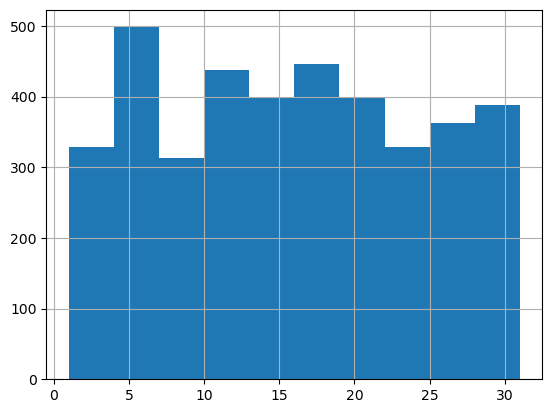

In [93]:
start_date['day'].hist();
plt.xlabel("Day of Month")
plt.ylabel("Number of Events");

**Question:** What observations or trends do you notice about this graph?

**Question:** What could be improved about this graph or the process we used to obtain the data that generated it?

## Sentiment Analysis
---
We can use the words the tweets to measure the sentiment, or the positive/negative feeling generated by the description text. To do so we will be using the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment), which is a rule-based sentiment analysis tool specifically designed for social media. It even includes emojis! Run the following cell to load in the lexicon.

In [83]:
vader = load_vader()
vader.iloc[500:510, :]

,polarity
sent,
ache,-1.6
ached,-1.6
aches,-1.0
achievable,1.3
aching,-2.2
acquit,0.8
acquits,0.1
acquitted,1.0
acquitting,1.3


The more positive the polarity of a word, the more positive feeling the word evokes in the reader. All of the words in `vader` are all lowercase, while many of our tweets are not. We need to modify the text in the tweets so that the words in our tweets will match up with the words stored in `vader`. Additionally, we need to remove punctuation since that will cause the words to not match up as well. We will put these modified tweets into another column in our `DataFrame` so that we can still have access to them later.

In [84]:
# Select our columns of interest
# polarity by age / event type?
descriptions = tpl_events_long[['id', 'library', 'description']].drop_duplicates()

# Set the index of the DataFrame to the tweet ID. This step is necessary
# in order to use our utility functions.
descriptions.set_index('id', inplace = True)

# Remove punctuation and lowercase tweets
descriptions['cleaned'] = clean_string(descriptions['description'])

descriptions.head()

,library,description,cleaned
id,,,
498234,Lillian H. Smith,"Celebrating the 200th anniversary of the first English translation of the folk and fairy tales of the Brothers Grimm. Featuring tales collected by German linguists and folklorists Jacob and Wilhelm Grimm. Beloved tales including Snow White, Little Red Riding Hood, Hansel & Gr...",celebrating the 200th anniversary of the first english translation of the folk and fairy tales of the brothers grimm featuring tales collected by german linguists and folklorists jacob and wilhelm grimm beloved tales including snow white little red riding hood hansel gr...
487820,Lillian H. Smith,"Every dog has its day in this exhibit at the Osborne Collection of Early Children's Books. From Old Yeller to Lassie to Harry the Dirty Dog, fall in puppy love with all the books that celebrate our best friends. <br /><br />July 31 - October 14 <br /><br />Free. All are welc...",every dog has its day in this exhibit at the osborne collection of early children s books from old yeller to lassie to harry the dirty dog fall in puppy love with all the books that celebrate our best friends br br july 31 october 14 br br free all are welc...
498446,Maria A. Shchuka,"Storytimes, crafts and games for children 0-10 years old.<br />Time: 3-4pm, every Sunday, October to December.",storytimes crafts and games for children 0 10 years old br time 3 4pm every sunday october to december
497432,St. Clair/Silverthorn,"Join us every Wednesday from 4-5pm with Pop up Learning Labs as we explore the world of tech, Coding 3D printing and 3D design. <br /><br />Scratch Coding <br />Wednesday October 4th 2023 <br /><br />3D Design for kids <br />Wednesday October 11th 2023<br /><br />Makey Makey<...",join us every wednesday from 4 5pm with pop up learning labs as we explore the world of tech coding 3d printing and 3d design br br scratch coding br wednesday october 4th 2023 br br 3d design for kids br wednesday october 11th 2023 br br makey makey ...
494626,Lillian H. Smith,"Whether they're made of metal, mud or magic, fiction is full of fantastic human-shaped creatures that aren't quite human. There are golems and robots, puppets and clones, magical constructs and more. Come and explore their stories at this exhibit!<br /><br />Free. All are wel...",whether they re made of metal mud or magic fiction is full of fantastic human shaped creatures that aren t quite human there are golems and robots puppets and clones magical constructs and more come and explore their stories at this exhibit br br free all are wel...


Next, we want to merge our sentiment lexicon with our cleaned tweets. 

In [85]:
descriptions['polarity'] = compose_polarity(descriptions, vader)
descriptions.head()

,library,description,cleaned,polarity
id,,,,
498234,Lillian H. Smith,"Celebrating the 200th anniversary of the first English translation of the folk and fairy tales of the Brothers Grimm. Featuring tales collected by German linguists and folklorists Jacob and Wilhelm Grimm. Beloved tales including Snow White, Little Red Riding Hood, Hansel & Gr...",celebrating the 200th anniversary of the first english translation of the folk and fairy tales of the brothers grimm featuring tales collected by german linguists and folklorists jacob and wilhelm grimm beloved tales including snow white little red riding hood hansel gr...,9.3
487820,Lillian H. Smith,"Every dog has its day in this exhibit at the Osborne Collection of Early Children's Books. From Old Yeller to Lassie to Harry the Dirty Dog, fall in puppy love with all the books that celebrate our best friends. <br /><br />July 31 - October 14 <br /><br />Free. All are welc...",every dog has its day in this exhibit at the osborne collection of early children s books from old yeller to lassie to harry the dirty dog fall in puppy love with all the books that celebrate our best friends br br july 31 october 14 br br free all are welc...,13.6
498446,Maria A. Shchuka,"Storytimes, crafts and games for children 0-10 years old.<br />Time: 3-4pm, every Sunday, October to December.",storytimes crafts and games for children 0 10 years old br time 3 4pm every sunday october to december,0.0
497432,St. Clair/Silverthorn,"Join us every Wednesday from 4-5pm with Pop up Learning Labs as we explore the world of tech, Coding 3D printing and 3D design. <br /><br />Scratch Coding <br />Wednesday October 4th 2023 <br /><br />3D Design for kids <br />Wednesday October 11th 2023<br /><br />Makey Makey<...",join us every wednesday from 4 5pm with pop up learning labs as we explore the world of tech coding 3d printing and 3d design br br scratch coding br wednesday october 4th 2023 br br 3d design for kids br wednesday october 11th 2023 br br makey makey ...,2.5
494626,Lillian H. Smith,"Whether they're made of metal, mud or magic, fiction is full of fantastic human-shaped creatures that aren't quite human. There are golems and robots, puppets and clones, magical constructs and more. Come and explore their stories at this exhibit!<br /><br />Free. All are wel...",whether they re made of metal mud or magic fiction is full of fantastic human shaped creatures that aren t quite human there are golems and robots puppets and clones magical constructs and more come and explore their stories at this exhibit br br free all are wel...,6.9


Next, we want to see if more polarizing tweets are retweeted more often. To do this, we can plot the `polarity` and `retweet_count` columns against each other.

In [ ]:
tweets_and_retweets.plot('polarity', 'retweet_count', kind='scatter');

**Question:** What conclusions can you draw about polarity and retweets from this graph? How does this compare with your assumptions?

## Your turn!
---
If time allows, try these exercises on your own or as a class!

**Exercise 1:** Using the `gentrification_oak` tweets, make a histogram of the time of day the tweets were posted. Note that if you would like the x-axis of the plot to reflect the correct time of day, you will have to convert the time from UTC to PDT.

In [ ]:
# YOUR CODE HERE

**Exercise 2:** Try scraping tweets from multiple locations and the same hashtag. Make a histogram for each location and see if there are any differences in the distribution of polarity of the tweets. Feel free to use multiple cells to avoid querying the API repeatedly.

In [ ]:
# YOUR CODE HERE